In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 2

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
class SimpsonCNN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # 224
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 110
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        # 54
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 26
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        # 12
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 5        
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, n_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop1(self.conv2(x))
        x = self.conv3(x)
        x = self.drop2(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 256)
        x = self.drop3(self.fc1(x))        
        x = self.fc2(x)        
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.AdamW(model.parameters())
        opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=10, verbose=False)
        #scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        best_acc = 0.0
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_acc)
            #scheduler.step()
            
            if val_acc > best_acc:
                best_model_wghts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wghts, './model/simpson.mdl')
                best_acc = val_acc
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [9]:
n_classes = len(np.unique(train_val_labels))
print(n_classes)
clf = SimpsonCNN(n_classes).to(DEVICE)
#clf = ConvModel(n_classes).to(DEVICE)
#print(clf)
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))


42
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
              ReLU-2         [-1, 32, 220, 220]               0
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 32, 108, 108]           9,248
              ReLU-5         [-1, 32, 108, 108]               0
         MaxPool2d-6           [-1, 32, 54, 54]               0
         Dropout2d-7           [-1, 32, 54, 54]               0
            Conv2d-8           [-1, 64, 52, 52]          18,496
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
        Dropout2d-14          [-1, 1

In [10]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [11]:
submit = pd.DataFrame(columns=['Id'])

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


FOLD 1
loss 3.2494807405444783


epoch:   3%|██▌                                                                        | 1/30 [01:48<52:40, 108.99s/it]


Epoch 001 train_loss: 3.2495     val_loss 2.7414 train_acc 0.1797 val_acc 0.2655
loss 2.610018082317787


epoch:   7%|█████                                                                       | 2/30 [02:55<44:58, 96.38s/it]


Epoch 002 train_loss: 2.6100     val_loss 2.5270 train_acc 0.2815 val_acc 0.2971
loss 2.356934075641815


epoch:  10%|███████▌                                                                    | 3/30 [04:02<39:20, 87.44s/it]


Epoch 003 train_loss: 2.3569     val_loss 2.2722 train_acc 0.3452 val_acc 0.3706
loss 2.1528200597853697


epoch:  13%|██████████▏                                                                 | 4/30 [05:09<35:15, 81.35s/it]


Epoch 004 train_loss: 2.1528     val_loss 2.1534 train_acc 0.3980 val_acc 0.3992
loss 1.919066365464758


epoch:  17%|████████████▋                                                               | 5/30 [06:20<32:37, 78.29s/it]


Epoch 005 train_loss: 1.9191     val_loss 1.9312 train_acc 0.4641 val_acc 0.4698
loss 1.6850586357886228


epoch:  20%|███████████████▏                                                            | 6/30 [07:36<30:58, 77.45s/it]


Epoch 006 train_loss: 1.6851     val_loss 1.7139 train_acc 0.5242 val_acc 0.5285
loss 1.4310143198074137


epoch:  23%|█████████████████▋                                                          | 7/30 [08:52<29:33, 77.12s/it]


Epoch 007 train_loss: 1.4310     val_loss 1.5033 train_acc 0.5959 val_acc 0.5880
loss 1.2413352039846632


epoch:  27%|████████████████████▎                                                       | 8/30 [10:09<28:17, 77.15s/it]


Epoch 008 train_loss: 1.2413     val_loss 1.4254 train_acc 0.6431 val_acc 0.6122
loss 1.0517850783214833


epoch:  30%|██████████████████████▊                                                     | 9/30 [11:24<26:47, 76.54s/it]


Epoch 009 train_loss: 1.0518     val_loss 1.2675 train_acc 0.6968 val_acc 0.6587
loss 0.8872543902531366


epoch:  33%|█████████████████████████                                                  | 10/30 [12:39<25:17, 75.86s/it]


Epoch 010 train_loss: 0.8873     val_loss 1.2284 train_acc 0.7416 val_acc 0.6738
loss 0.7391225543126081


epoch:  37%|███████████████████████████▍                                               | 11/30 [13:55<24:02, 75.90s/it]


Epoch 011 train_loss: 0.7391     val_loss 1.2132 train_acc 0.7788 val_acc 0.6874
loss 0.655204537504608


epoch:  40%|██████████████████████████████                                             | 12/30 [15:09<22:37, 75.44s/it]


Epoch 012 train_loss: 0.6552     val_loss 1.1806 train_acc 0.8005 val_acc 0.7039
loss 0.5298808737819922


epoch:  43%|████████████████████████████████▌                                          | 13/30 [16:23<21:14, 74.97s/it]


Epoch 013 train_loss: 0.5299     val_loss 1.1189 train_acc 0.8422 val_acc 0.7227
loss 0.41709029082187427


epoch:  47%|███████████████████████████████████                                        | 14/30 [17:36<19:47, 74.24s/it]


Epoch 014 train_loss: 0.4171     val_loss 1.1820 train_acc 0.8735 val_acc 0.7219
loss 0.36295617875969627


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [18:53<18:48, 75.24s/it]


Epoch 015 train_loss: 0.3630     val_loss 1.1780 train_acc 0.8882 val_acc 0.7322
loss 0.3038930446168224


epoch:  53%|████████████████████████████████████████                                   | 16/30 [20:04<17:17, 74.08s/it]


Epoch 016 train_loss: 0.3039     val_loss 1.1854 train_acc 0.9062 val_acc 0.7382
loss 0.27053239700847165


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [21:17<15:57, 73.67s/it]


Epoch 017 train_loss: 0.2705     val_loss 1.2435 train_acc 0.9174 val_acc 0.7336
loss 0.2396443694772749


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [22:29<14:38, 73.22s/it]


Epoch 018 train_loss: 0.2396     val_loss 1.2807 train_acc 0.9270 val_acc 0.7448
loss 0.21110535464975938


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [23:41<13:21, 72.85s/it]


Epoch 019 train_loss: 0.2111     val_loss 1.2407 train_acc 0.9346 val_acc 0.7475
loss 0.1840155508434229


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [24:52<12:03, 72.34s/it]


Epoch 020 train_loss: 0.1840     val_loss 1.2693 train_acc 0.9427 val_acc 0.7569
loss 0.13018205838301256


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [26:01<10:42, 71.33s/it]


Epoch 021 train_loss: 0.1302     val_loss 1.3600 train_acc 0.9601 val_acc 0.7497
loss 0.13627607893274643


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [27:08<09:17, 69.75s/it]


Epoch 022 train_loss: 0.1363     val_loss 1.2912 train_acc 0.9608 val_acc 0.7620
loss 0.12672552332809048


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [28:22<08:18, 71.23s/it]


Epoch 023 train_loss: 0.1267     val_loss 1.3754 train_acc 0.9616 val_acc 0.7530
loss 0.10536456499379808


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [29:40<07:19, 73.26s/it]


Epoch 024 train_loss: 0.1054     val_loss 1.3502 train_acc 0.9666 val_acc 0.7647
loss 0.08917534743792874


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [30:57<06:11, 74.21s/it]


Epoch 025 train_loss: 0.0892     val_loss 1.3933 train_acc 0.9727 val_acc 0.7685
loss 0.09621058236172689


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [32:15<05:01, 75.31s/it]


Epoch 026 train_loss: 0.0962     val_loss 1.2808 train_acc 0.9711 val_acc 0.7665
loss 0.05938149182461076


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [33:31<03:47, 75.69s/it]


Epoch 027 train_loss: 0.0594     val_loss 1.3396 train_acc 0.9835 val_acc 0.7815
loss 0.05433068723323946


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [34:48<02:32, 76.18s/it]


Epoch 028 train_loss: 0.0543     val_loss 1.4140 train_acc 0.9847 val_acc 0.7783
loss 0.0835164908204307


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [36:01<01:15, 75.05s/it]


Epoch 029 train_loss: 0.0835     val_loss 1.6891 train_acc 0.9747 val_acc 0.7479
loss 0.06457188072805266


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [37:17<00:00, 74.58s/it]


Epoch 030 train_loss: 0.0646     val_loss 1.4642 train_acc 0.9802 val_acc 0.7776


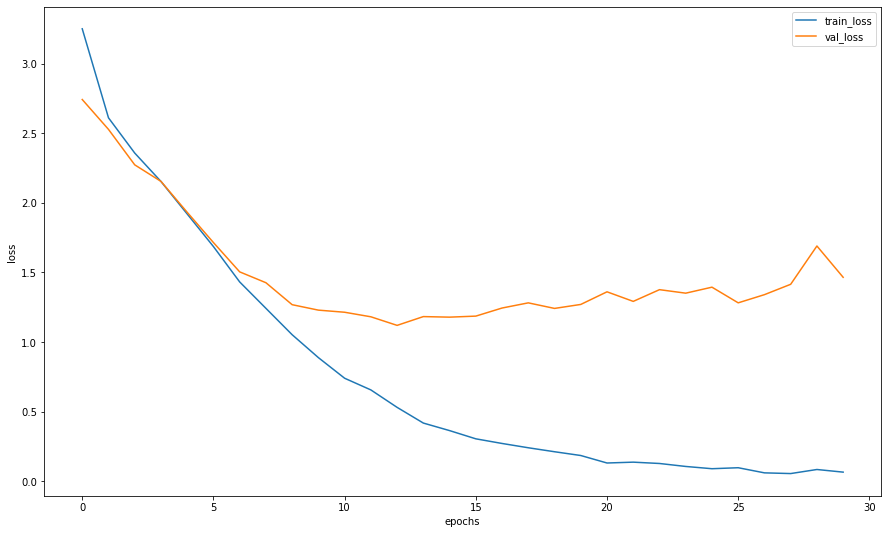

In [12]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = SimpsonCNN(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds
    break

In [14]:
torch.cuda.empty_cache()

###  Submission

In [13]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('submission_custom_kfold_sgd-2_lrp.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,barney_gumble,barney_gumble
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
